# Mirico Technical Interview – Methane Threshold Baseline

This notebook follows the assignment instructions:
1. Exploratory Data Analysis (EDA)
2. Flat-threshold anomaly detection on CH₄ (ppm)
3. Time-based performance evaluation vs truth windows
4. Forward-looking improvements

## Key constraints from the brief
- Use only `measurement_validity == 10` (good data)
- Evaluate as a single flat time series (do not evaluate per retro)
- Detection must use a single global threshold (one value)


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 50)

DATA_MEAS = Path("measurement_data.csv")
DATA_TRUTH = Path("truth_data.csv")
SITE_IMG = Path("Mirico_site_layout.png")

# 0) Load data
meas_raw = pd.read_csv(DATA_MEAS)
truth_raw = pd.read_csv(DATA_TRUTH)

print("measurement_data.csv:", meas_raw.shape)
print("truth_data.csv:", truth_raw.shape)

meas_raw.head()


measurement_data.csv: (85269, 9)
truth_data.csv: (34, 7)


,timestamp,ch4_ppm,windx_m_per_s,windy_m_per_s,windz_m_per_s,temperature_k,pressure_torr,measurement_validity,retro_name_id
0,2025-06-16 00:00:04.412000000,1.964220,0.200,-0.651,0.102,291.7125,759.009919,10,R3
1,2025-06-16 00:00:05.251000064,1.974093,0.200,-0.651,0.102,291.7125,759.009919,10,R3
2,2025-06-16 00:00:05.988000000,1.967110,0.200,-0.651,0.102,291.7125,759.009919,10,R3
3,2025-06-16 00:00:22.424999936,1.932974,0.474,-0.795,-0.057,291.6500,758.972415,10,R4
4,2025-06-16 00:00:23.172000000,1.927993,0.474,-0.795,-0.057,291.6500,758.972415,10,R4


## Site layout (context only)
The NG5 sensor and retros (R1–R14) are shown below (provided by Mirico).

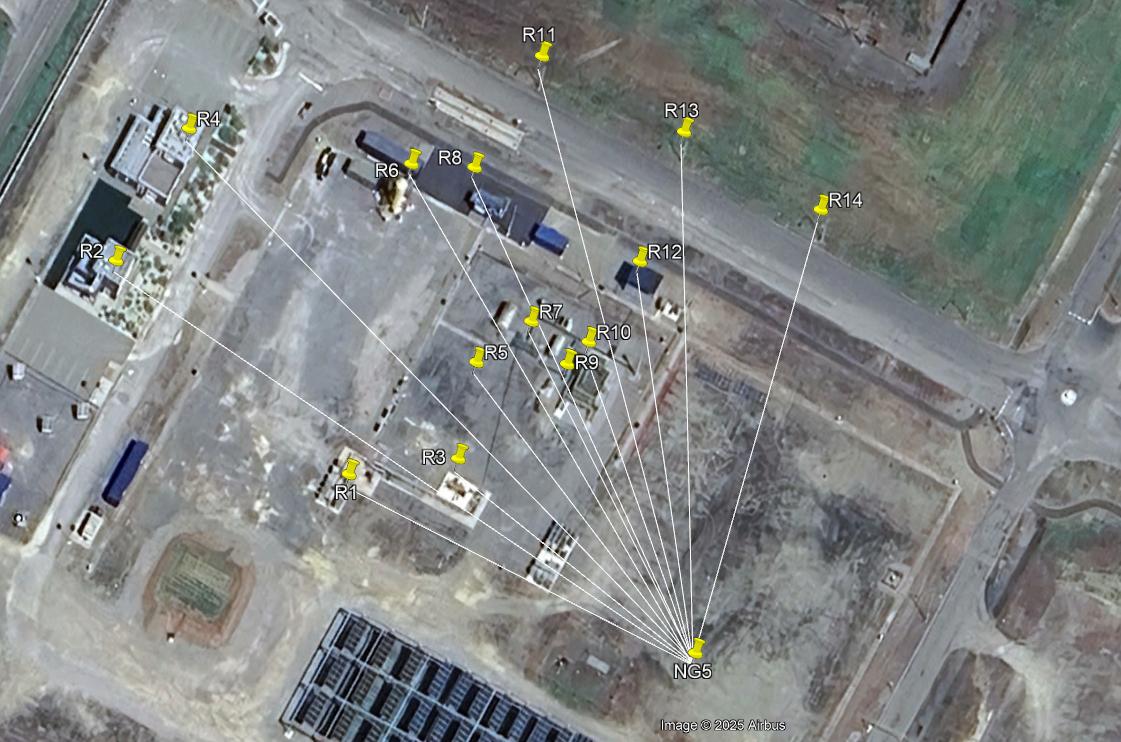

In [103]:
from PIL import Image
from IPython.display import display

if SITE_IMG.exists():
    display(Image.open(SITE_IMG))
else:
    print("Site layout image not found:", SITE_IMG)


## 1) Cleaning + feature derivations
Wind speed/direction are derived for EDA only (not used for thresholding).

In [104]:
meas = meas_raw.copy()

# Parse timestamps
meas["timestamp"] = pd.to_datetime(meas["timestamp"], errors="coerce")
meas = meas.dropna(subset=["timestamp", "ch4_ppm"]).sort_values("timestamp")

# Keep only good data
meas = meas[meas["measurement_validity"] == 10].copy()

# Derive horizontal wind speed + direction (EDA only)
wx = meas["windx_m_per_s"].astype(float)
wy = meas["windy_m_per_s"].astype(float)
meas["wind_horiz_speed_m_per_s"] = np.hypot(wx, wy)
meas["wind_horiz_dir_deg"] = (np.degrees(np.arctan2(wy, wx)) + 360.0) % 360.0

meas.shape, meas.head()


((84625, 11),
                       timestamp   ch4_ppm  windx_m_per_s  windy_m_per_s  \
 0 2025-06-16 00:00:04.412000000  1.964220          0.200         -0.651   
 1 2025-06-16 00:00:05.251000064  1.974093          0.200         -0.651   
 2 2025-06-16 00:00:05.988000000  1.967110          0.200         -0.651   
 3 2025-06-16 00:00:22.424999936  1.932974          0.474         -0.795   
 4 2025-06-16 00:00:23.172000000  1.927993          0.474         -0.795   
 
    windz_m_per_s  temperature_k  pressure_torr  measurement_validity  \
 0          0.102       291.7125     759.009919                    10   
 1          0.102       291.7125     759.009919                    10   
 2          0.102       291.7125     759.009919                    10   
 3         -0.057       291.6500     758.972415                    10   
 4         -0.057       291.6500     758.972415                    10   
 
   retro_name_id  wind_horiz_speed_m_per_s  wind_horiz_dir_deg  
 0            R3       

## Parse truth windows
Use the provided start / end columns (already fully qualified timestamps).

In [105]:
truth = truth_raw.copy()
truth["start"] = pd.to_datetime(truth["start"], errors="coerce")
truth["end"] = pd.to_datetime(truth["end"], errors="coerce")
truth = truth.dropna(subset=["start", "end"]).sort_values("start").reset_index(drop=True)

truth[["start", "end", "kg/h"]].head()


,start,end,kg/h
0,2025-06-16 06:57:00,2025-06-16 07:45:00,3.60
1,2025-06-16 07:57:30,2025-06-16 08:45:10,7.92
2,2025-06-16 09:00:00,2025-06-16 10:00:00,1.80
3,2025-06-16 10:13:00,2025-06-16 11:10:00,2.88
4,2025-06-16 11:25:00,2025-06-16 12:00:00,104.40


## 2) Exploratory Data Analysis (EDA)
A typical global background methane concentration is ~2 ppm. We look for excursions above this background.

In [106]:
meas[["ch4_ppm", "temperature_k", "pressure_torr", "wind_horiz_speed_m_per_s"]].describe()

,ch4_ppm,temperature_k,pressure_torr,wind_horiz_speed_m_per_s
count,84625.000000,84625.000000,84625.000000,84625.000000
mean,2.173546,297.739792,754.519164,1.169225
std,1.501563,6.424116,1.855415,0.903159
min,1.741804,286.525000,751.464298,0.009000
25%,1.927228,291.650000,752.836911,0.513361
50%,1.971427,297.337500,754.442043,0.884274
75%,2.071991,302.775000,755.619640,1.586748
max,104.217922,310.962500,759.069924,8.254201


In [107]:
# Missingness & retro counts (retro is contextual only; evaluation is flat)
display(meas.isna().mean().sort_values(ascending=False).head(12))
display(meas["retro_name_id"].value_counts())


timestamp                   0.0
ch4_ppm                     0.0
windx_m_per_s               0.0
windy_m_per_s               0.0
windz_m_per_s               0.0
temperature_k               0.0
pressure_torr               0.0
measurement_validity        0.0
retro_name_id               0.0
wind_horiz_speed_m_per_s    0.0
wind_horiz_dir_deg          0.0
dtype: float64

retro_name_id
R7     6090
R6     6090
R12    6090
R9     6090
R10    6087
R8     6085
R13    6082
R5     6066
R3     6059
R1     6056
R11    6043
R14    6036
R2     5971
R4     5780
Name: count, dtype: int64

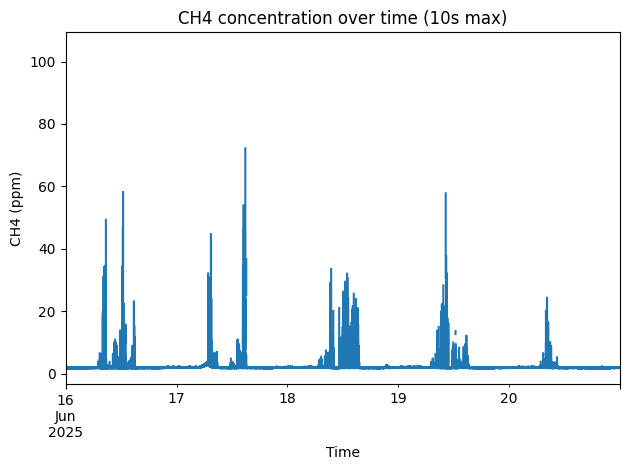

In [108]:
# CH4 over time (10s max to reduce overplotting)
ch4_10s = meas.set_index("timestamp")["ch4_ppm"].resample("10s").max()
plt.figure()
ch4_10s.plot()
plt.xlabel("Time")
plt.ylabel("CH4 (ppm)")
plt.title("CH4 concentration over time (10s max)")
plt.tight_layout()
plt.show()


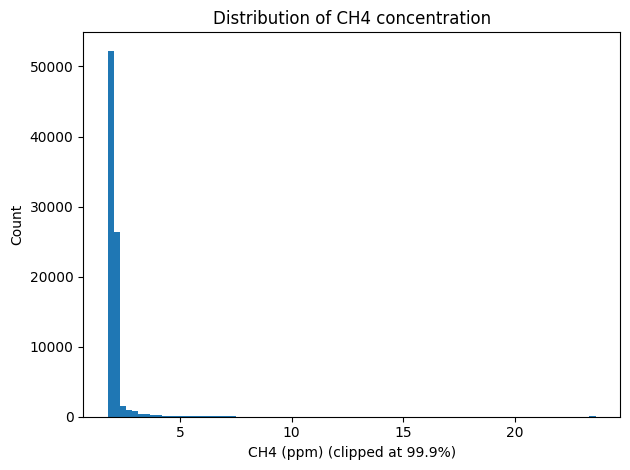

In [109]:
# CH4 distribution (clip extreme tail for readability)
clip_val = meas["ch4_ppm"].quantile(0.999)
plt.figure()
plt.hist(meas["ch4_ppm"].clip(upper=clip_val), bins=80)
plt.xlabel("CH4 (ppm) (clipped at 99.9%)")
plt.ylabel("Count")
plt.title("Distribution of CH4 concentration")
plt.tight_layout()
plt.show()


### Notes from EDA
- **Normal:** values cluster tightly around ~2 ppm with modest variability.
- **Unusual:** sharp spikes and sustained elevated periods, sometimes reaching tens of ppm and occasionally > 100 ppm.
- **Data limitations:** sensor cycles between retro paths; the raw data are not a continuous 1 Hz time series.
- Because the brief asks for a flat timeseries evaluation, we avoid per-retro modelling here.


## 3) Label data with truth windows + make 1 Hz bins
For pragmatic time-based evaluation, we aggregate to per-second maxima of CH₄ across all samples occurring within that second.


In [110]:
def add_truth_label(meas_df: pd.DataFrame, truth_df: pd.DataFrame) -> pd.DataFrame:
    """Assign a truth label (0/1) to each measurement row if its timestamp lies within any truth window."""
    starts = truth_df["start"].values.astype("datetime64[ns]")
    ends = truth_df["end"].values.astype("datetime64[ns]")
    ts = meas_df["timestamp"].values.astype("datetime64[ns]")

    # Find the last window start before each timestamp
    idx = np.searchsorted(starts, ts, side="right") - 1
    in_window = (idx >= 0) & (ts <= ends[idx])

    out = meas_df.copy()
    out["truth"] = in_window.astype(int)
    return out


def to_second_bins(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate to 1 Hz (per-second) bins using max CH4 and max truth label."""
    tmp = df[["timestamp", "ch4_ppm", "truth"]].copy()
    tmp["t_sec"] = tmp["timestamp"].dt.floor("s")
    sec = (
        tmp.groupby("t_sec")
        .agg(ch4_ppm=("ch4_ppm", "max"), truth=("truth", "max"), n=("ch4_ppm", "size"))
        .reset_index()
        .rename(columns={"t_sec": "timestamp"})
        .sort_values("timestamp")
    )
    return sec


meas_l = add_truth_label(meas, truth)
sec = to_second_bins(meas_l)

sec.head(), sec.shape


(            timestamp   ch4_ppm  truth  n
 0 2025-06-16 00:00:04  1.964220      0  1
 1 2025-06-16 00:00:05  1.974093      0  2
 2 2025-06-16 00:00:22  1.932974      0  1
 3 2025-06-16 00:00:23  1.927993      0  1
 4 2025-06-16 00:00:24  1.935485      0  1,
 (73381, 4))

Coverage note: the sensor is not sampling every second. We evaluate only on observed seconds to avoid inventing values in the gaps.

In [111]:
full_seconds = int((sec["timestamp"].max() - sec["timestamp"].min()).total_seconds()) + 1
coverage = sec.shape[0] / full_seconds
print(f"Observed seconds: {sec.shape[0]:,} / {full_seconds:,} (~{coverage:.1%} coverage)")


Observed seconds: 73,381 / 431,993 (~17.0% coverage)


## 4) Flat-threshold detector + tuning
We sweep candidate thresholds and compute simple time-bin metrics:
- **True positive time** = fraction of truth-anomalous seconds that are detected (recall)
- **False positive time** = fraction of detected-anomalous seconds that do not overlap truth (1 - precision)


In [112]:
def compute_metrics(sec_df: pd.DataFrame, threshold_ppm: float) -> dict:
    pred = (sec_df["ch4_ppm"] > threshold_ppm).astype(int)
    truth_lbl = sec_df["truth"].astype(int)

    tp = int(((pred == 1) & (truth_lbl == 1)).sum())
    fp = int(((pred == 1) & (truth_lbl == 0)).sum())
    fn = int(((pred == 0) & (truth_lbl == 1)).sum())
    tn = int(((pred == 0) & (truth_lbl == 0)).sum())

    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

    return dict(
        threshold_ppm=float(threshold_ppm),
        precision=float(precision),
        recall=float(recall),
        f1=float(f1),
        true_positive_time=float(recall),
        false_positive_time=float(fp / (tp + fp) if (tp + fp) else 0.0),
        tp=tp,
        fp=fp,
        fn=fn,
        tn=tn,
    )


def tune_threshold(sec_df: pd.DataFrame, thresholds: np.ndarray) -> pd.DataFrame:
    rows = [compute_metrics(sec_df, float(t)) for t in thresholds]
    return pd.DataFrame(rows)


threshold_grid = np.round(np.arange(1.9, 6.01, 0.01), 2)
tuned = tune_threshold(sec, threshold_grid)

# Option A: raw "best F1" (often gives unacceptably high false positives)
best_f1 = tuned.sort_values(["f1", "recall"], ascending=False).iloc[0]

# Option B: choose best F1 subject to a minimum precision (more practical)
min_precision = 0.70
best_practical = (
    tuned[tuned["precision"] >= min_precision]
    .sort_values(["f1", "recall"], ascending=False)
    .iloc[0]
)

display(best_f1)
display(best_practical)


threshold_ppm              1.920000
precision                  0.242498
recall                     0.865977
f1                         0.378895
true_positive_time         0.865977
false_positive_time        0.757502
tp                     14312.000000
fp                     44707.000000
fn                      2215.000000
tn                     12147.000000
Name: 2, dtype: float64

threshold_ppm              2.230000
precision                  0.708890
recall                     0.256671
f1                         0.376882
true_positive_time         0.256671
false_positive_time        0.291110
tp                      4242.000000
fp                      1742.000000
fn                     12285.000000
tn                     55112.000000
Name: 33, dtype: float64

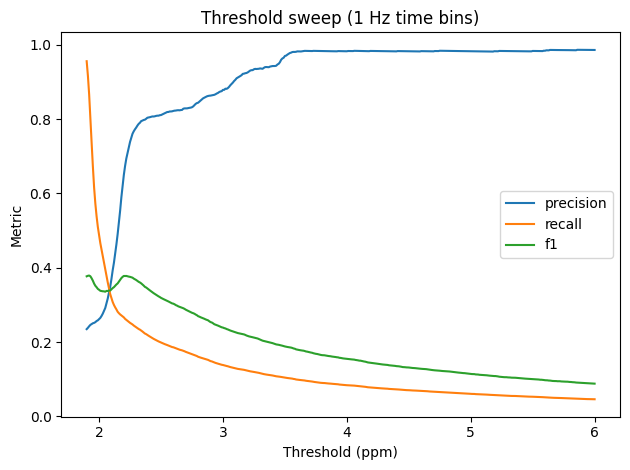

In [113]:
plt.figure()
plt.plot(tuned["threshold_ppm"], tuned["precision"], label="precision")
plt.plot(tuned["threshold_ppm"], tuned["recall"], label="recall")
plt.plot(tuned["threshold_ppm"], tuned["f1"], label="f1")
plt.xlabel("Threshold (ppm)")
plt.ylabel("Metric")
plt.title("Threshold sweep (1 Hz time bins)")
plt.legend()
plt.tight_layout()
plt.show()


## Threshold choice used for deliverables
A pure F1 optimum can occur at a very low threshold, which detects most truth time but produces excessive false positives.
For a more usable baseline, select the best threshold with precision ≥ 0.70.
This is still a single global threshold; the constraint is only used to pick a point on the precision–recall trade-off curve.


In [114]:
threshold_ppm = float(best_practical["threshold_ppm"])
threshold_ppm


2.23

## 5) Convert exceedances to detected anomaly windows
We convert per-second threshold exceedances into windows by merging exceedances separated by short gaps (`gap_tolerance_s`)
and dropping extremely short events (`min_duration_s`). This is post-processing only; the detector remains a single flat threshold.


In [115]:
def exceedances_to_windows(
    sec_df: pd.DataFrame,
    threshold_ppm: float,
    gap_tolerance_s: int = 30,
    min_duration_s: int = 10,
) -> pd.DataFrame:
    df = sec_df[["timestamp", "ch4_ppm"]].copy()
    df["anomaly"] = (df["ch4_ppm"] > threshold_ppm).astype(int)

    pos = df[df["anomaly"] == 1].copy()
    if pos.empty:
        return pd.DataFrame(columns=["start", "end", "duration_s"])

    pos = pos.sort_values("timestamp")
    dt = pos["timestamp"].diff().dt.total_seconds().fillna(0)
    group_id = (dt > (gap_tolerance_s + 1)).cumsum()

    windows = (
        pos.groupby(group_id)
        .agg(start=("timestamp", "min"), end=("timestamp", "max"))
        .reset_index(drop=True)
    )
    windows["duration_s"] = (windows["end"] - windows["start"]).dt.total_seconds().astype(int) + 1
    windows = windows[windows["duration_s"] >= min_duration_s].reset_index(drop=True)
    return windows


detected_windows = exceedances_to_windows(sec, threshold_ppm, gap_tolerance_s=30, min_duration_s=10)
detected_windows.head(), detected_windows.shape


(                start                 end  duration_s
 0 2025-06-16 06:59:20 2025-06-16 06:59:50          31
 1 2025-06-16 07:02:41 2025-06-16 07:02:57          17
 2 2025-06-16 07:03:41 2025-06-16 07:03:56          16
 3 2025-06-16 07:06:25 2025-06-16 07:07:24          60
 4 2025-06-16 07:13:10 2025-06-16 07:14:39          90,
 (388, 3))

### Visual alignment with truth

Plot a shorter window for readability and show truth release windows as thick bars.

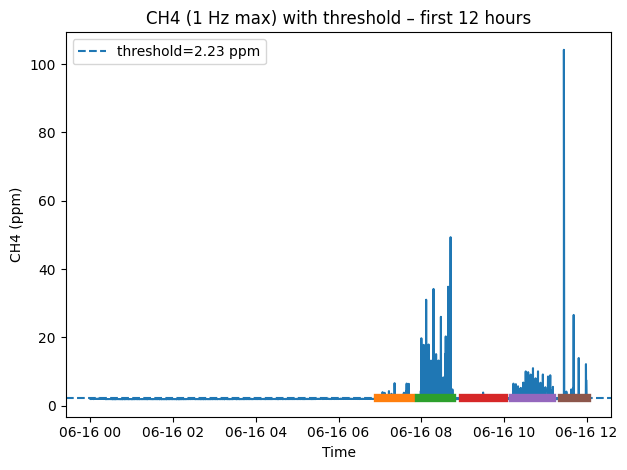

In [116]:

start_plot = sec["timestamp"].min()
end_plot = start_plot + pd.Timedelta(hours=12)
view = sec[(sec["timestamp"] >= start_plot) & (sec["timestamp"] <= end_plot)].copy()

plt.figure()
plt.plot(view["timestamp"], view["ch4_ppm"])
plt.axhline(threshold_ppm, linestyle="--", label=f"threshold={threshold_ppm:.2f} ppm")
plt.xlabel("Time")
plt.ylabel("CH4 (ppm)")
plt.title("CH4 (1 Hz max) with threshold – first 12 hours")

# Truth shading (as thick horizontal segments at the threshold level)
for _, row in truth.iterrows():
    if row["end"] < start_plot or row["start"] > end_plot:
        continue
    plt.plot([row["start"], row["end"]], [threshold_ppm, threshold_ppm], linewidth=6)

plt.legend()
plt.tight_layout()
plt.show()


## 6) Performance evaluation (time-based)
We report time-based metrics on the per-second series:

In [117]:
metrics = compute_metrics(sec, threshold_ppm)
metrics


{'threshold_ppm': 2.23,
 'precision': 0.7088903743315508,
 'recall': 0.25667090216010163,
 'f1': 0.3768824130425126,
 'true_positive_time': 0.25667090216010163,
 'false_positive_time': 0.2911096256684492,
 'tp': 4242,
 'fp': 1742,
 'fn': 12285,
 'tn': 55112}

## 7) Export deliverables
- `labelled_seconds.csv`: 1 Hz dataframe with truth + predicted anomaly  
- `detected_windows.csv`: merged anomaly windows  
- `threshold_sweep_metrics.csv`: sweep results across thresholds


In [118]:
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

labelled = sec.copy()
labelled["pred_anomaly"] = (labelled["ch4_ppm"] > threshold_ppm).astype(int)

labelled_path = OUT_DIR / "labelled_seconds.csv"
windows_path = OUT_DIR / "detected_windows.csv"
sweep_path = OUT_DIR / "threshold_sweep_metrics.csv"  # export sweep metrics

labelled.to_csv(labelled_path, index=False)
detected_windows.to_csv(windows_path, index=False)
tuned.to_csv(sweep_path, index=False)  

labelled_path, windows_path, sweep_path


(WindowsPath('outputs/labelled_seconds.csv'),
 WindowsPath('outputs/detected_windows.csv'),
 WindowsPath('outputs/threshold_sweep_metrics.csv'))

## 8) Forward-looking improvements (high-level)
If given more time, I would improve this baseline by:
- Sampling / alignment improvements robust to irregular sampling
- Per-retro normalisation
- Adaptive thresholds
- Use wind features
- Better windowing (hysteresis)
- Event-based evaluation (IoU, latency, stratification by kg/h)
